In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4), cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

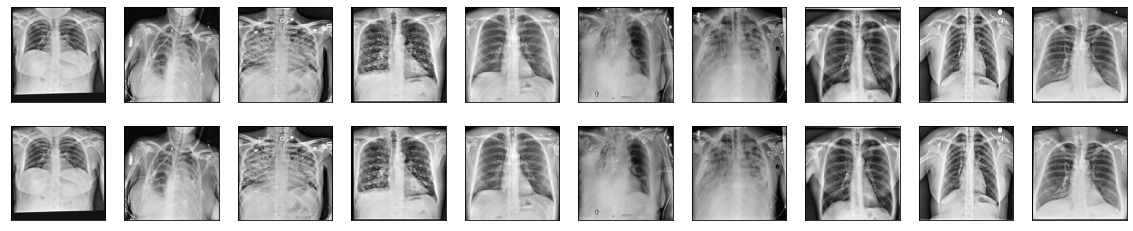

In [2]:
import glob
import imageio
import numpy as np
import cv2
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
sz,imgs=128,[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for png in pngs[:]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        # print('{0} {1} -> '.format(img.shape, img.dtype))
        img = rgb2gray(img)
        img = img_as_ubyte(img)
        # print('{0} {1}'.format(img.shape, img.dtype))
        # continue
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
show_original_decoded(imgs[:10], imgs[:10], sz)

In [3]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12072, 128, 128, 1) (1341, 128, 128, 1)


In [4]:
def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """
    Compute VAE loss, using either mse or crossentropy.
    # Arguments
        z_mean: mean of Q(z|X)
        z_log_var: log variance of Q(z|X)
        y_true, y_pred: truth and predicated values
    # Returns
        loss value
    """
    from tensorflow.keras.losses import mse, binary_crossentropy
    from keras import backend as K
    img_pixels = sz * sz
    use_mse = False
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

In [6]:
latent_dim = 6
def build_zebrastack_v0(sz, optimizer, plot_model = False):
    """
    build the encoder, decoder, and full model
    # Arguments
        sz: size x size of inputs
        optimizer: optimizer to use
        plot_model: flag to indicate whether to output plot model
    # Example
        autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta')
    """    
    from keras.layers import Dense, Input, SpatialDropout2D
    from keras.layers import Conv2D, Flatten, Lambda
    from keras.layers import LocallyConnected2D, ZeroPadding2D
    from keras.layers import MaxPooling2D, UpSampling2D
    from keras.layers import Reshape, Conv2DTranspose
    from keras.layers import ActivityRegularization
    from keras import backend as K
    # from keras.datasets import mnist
    # from keras.losses import mse, binary_crossentropy    

    # create encoder side
    input_img = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))
    x = Conv2D(16, (5,5), activation='relu', padding='same', name='v1_conv2d')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='v1_maxpool')(x)
    x = SpatialDropout2D(0.1, name='v1_dropout')(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same', name='v2_conv2d')(x)  # WHAT?!?!?
    x = MaxPooling2D((2,2), padding='same', name='v2_maxpool')(x)    
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='v4_conv2d')(x)
    x = MaxPooling2D((2,2), padding='same', name='v4_maxpool')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='pit_conv2d')(x)
    x = MaxPooling2D((2,2), padding='same', name='pit_maxpool')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='cit_conv2d')(x)
    x = MaxPooling2D((2,2), padding='same', name='cit_maxpool')(x)
    x = LocallyConnected2D(4, (3,3), name='ait_local')(x)
    x = ZeroPadding2D(padding=(1,1), name='ait_padding')(x)
    # x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    # print(shape)

    # generate latent vector Q(z|X)
    x = Flatten(name='pulvinar_flatten')(encoded_layer)
    x = Dense(latent_dim, activation='relu', name='pulvinar_dense')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    from keras.models import Model
    encoder = Model(input_img, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
    encoder.summary()
    
    from keras.utils import plot_model
    if plot_model: 
        plot_model(encoder, to_file='data\{}.png'.format(encoder.name), show_shapes=True)

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu', name='pulvinar_dense_back')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]), name='pulvinar_antiflatten')(x)

    x = LocallyConnected2D(4, (3,3), name='ait_local_back')(x)
    x = ZeroPadding2D(padding=(1,1), name='ait_padding_back')(x)
    x = UpSampling2D((2,2), name='ait_upsample_back')(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same', name='cit_conv2d_trans')(x)
    x = UpSampling2D((2,2), name='cit_upsample_back')(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same', name='pit_conv2d_trans')(x)
    x = UpSampling2D((2,2), name='pit_upsample_back')(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same', name='v4_conv2d_trans')(x)
    x = UpSampling2D((2,2), name='v4_upsample_back')(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same', name='v2_conv2d_trans')(x)
    x = UpSampling2D((2,2), name='v2_upsample_back')(x)
    decoded_layer = Conv2D(1, (5,5), activation='sigmoid', padding='same', name='v1_conv2d_1x1_back')(x)
    decoder = Model(latent_inputs, decoded_layer, name='pulvinar_to_v1_decoder')
    decoder.summary()
    if plot_model: 
        plot_model(decoder, to_file='data\{}.png'.format(decoder.name), show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='v1_to_pulvinar_vae')
    autoencoder.compile(optimizer=optimizer, 
                        loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
    autoencoder.summary()
    if plot_model: 
        plot_model(autoencoder, to_file='data\{}.png'.format(autoencoder.name), show_shapes=True)

    return autoencoder, encoder, decoder

In [7]:
autoencoder, encode_only, decode_only = build_zebrastack_v0(sz, 'adadelta')

Using TensorFlow backend.


Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

In [8]:
autoencoder.fit(x_train, x_train, 
                epochs=256, batch_size=512, 
                shuffle=True, validation_data=(x_test,x_test))

Train on 12072 samples, validate on 1341 samples
Epoch 1/256
12072/12072 [==============================] - 21s 2ms/step - loss: 12286.5927 - val_loss: 10869.0130
Epoch 2/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10812.3794 - val_loss: 10692.9770
Epoch 3/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10583.9026 - val_loss: 10491.4380
Epoch 4/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10450.6732 - val_loss: 10518.0808
Epoch 5/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10487.1043 - val_loss: 10352.5452
Epoch 6/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10335.6301 - val_loss: 10328.8920
Epoch 7/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10318.9020 - val_loss: 10473.8789
Epoch 8/256
12072/12072 [==============================] - 13s 1ms/step - loss: 10301.8291 - val_loss: 10338.4986
Epoch 9/256
12072/12072 [==============

12072/12072 [==============================] - 13s 1ms/step - loss: 9624.7889 - val_loss: 9678.1021
Epoch 73/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9605.5261 - val_loss: 9635.8916
Epoch 74/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9613.3863 - val_loss: 9630.2506
Epoch 75/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9613.0651 - val_loss: 9648.3783
Epoch 76/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9613.6902 - val_loss: 9634.3211
Epoch 77/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9602.5613 - val_loss: 9666.0408
Epoch 78/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9597.9744 - val_loss: 9637.4956
Epoch 79/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9601.0396 - val_loss: 9643.0070
Epoch 80/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9596.8894 - val_loss: 9608.8

12072/12072 [==============================] - 13s 1ms/step - loss: 9535.0019 - val_loss: 9567.1621
Epoch 145/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9531.7037 - val_loss: 9600.8826
Epoch 146/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9539.2162 - val_loss: 9582.2101
Epoch 147/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9529.2486 - val_loss: 9584.9333
Epoch 148/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9542.0646 - val_loss: 9595.5334
Epoch 149/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9538.3101 - val_loss: 9608.8980
Epoch 150/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9533.8862 - val_loss: 9606.9265
Epoch 151/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9544.9524 - val_loss: 9595.7207
Epoch 152/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9529.3000 - val_loss

Epoch 216/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9513.0620 - val_loss: 9566.0025
Epoch 217/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9520.4677 - val_loss: 9545.9077
Epoch 218/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9504.6301 - val_loss: 9552.7260
Epoch 219/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9509.1129 - val_loss: 9577.8494
Epoch 220/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9508.5570 - val_loss: 9604.5553
Epoch 221/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9519.9251 - val_loss: 9550.5671
Epoch 222/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9507.1380 - val_loss: 9584.4155
Epoch 223/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9509.8813 - val_loss: 9534.6063
Epoch 224/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9505.1

In [9]:
from functools import lru_cache

@lru_cache(maxsize=None)
def decode_latent(decode_only, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decode_only.predict(latent_vector_arr)

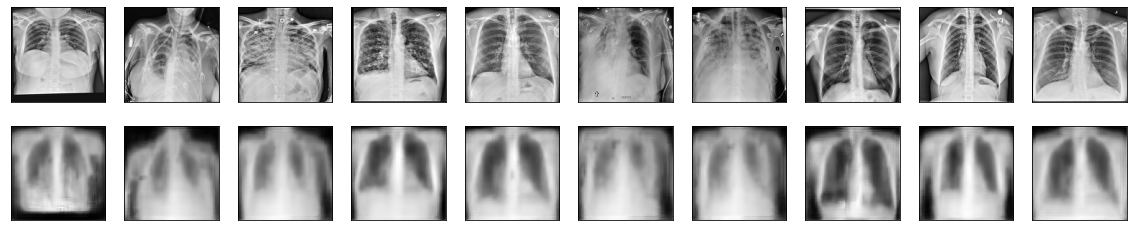

In [33]:
encode_only_imgs = encode_only.predict(x_test[:10])
showHisto = False
if showHisto:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = \
    [decode_latent(decode_only, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)

In [27]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decode_only, tuple(kwargs.values()))
    interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=5)
    interp_array = interp_array.reshape(sz*4, sz*4)
    plt.imshow(interp_array, cmap='gray')
    return kwargs['1']

Output(layout=Layout(height='350px'))

<IPython.core.display.Javascript object>


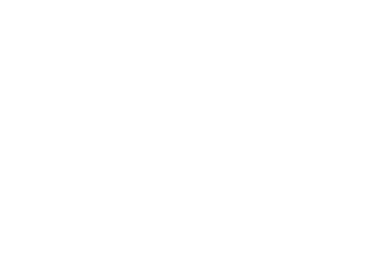

In [45]:
%matplotlib notebook
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}
for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)